In [24]:
import h5py
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import nexusformat.nexus as nx
import scipy as sp
from scipy import integrate
import pandas as pd
import librosa
import pickle

import ghostipy
from ghostipy.spectral.wavelets import MorseWavelet

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
filename = "dataset/pothole_depth.hdf5"
iisc_dataset = "Experiment_21_07_2023_IISc_Table/"
model_dir = 'model'
iisc_dataset_files = ["2023-07-21_11-34-57/Accelerometer.csv", "2023-07-21_11-35-04/Accelerometer.csv", "2023-07-21_11-35-10/Accelerometer.csv", "2023-07-21_11-35-15/Accelerometer.csv", "2023-07-21_11-35-41/Accelerometer.csv", "2023-07-21_11-35-52/Accelerometer.csv", "2023-07-21_11-36-06/Accelerometer.csv", "2023-07-21_11-36-17/Accelerometer.csv", "2023-07-21_11-37-29/Accelerometer.csv", "2023-07-21_11-37-36/Accelerometer.csv"]

In [3]:
f = nx.nxload(filename)
print(f.tree)

root:NXroot
  idx:NXgroup
    event:NXgroup
      0ad1a6ff-d6ae-40fb-a4df-982777f4760d:NXgroup
        0a78b7c5-3e77-4eeb-8a3c-071b17ec4ad5:NXgroup
          @depth = 6.5
          @dim1 = 65.0
          @dim2 = 43.0
          @event = '0ad1a6ff-d6ae-40fb-a4df-982777f4760d'
          @placement = 'Left door'
          @speed = 12.910843373493977
          @type = 'Pothole'
          @vehicle = 'Peugeot Partner 2013'
          acc_x = float64(249)
          acc_y = float64(249)
          acc_z = float64(249)
        df2bdf34-aa83-44b4-8a52-46dd5c66a2c6:NXgroup
          @depth = 6.5
          @dim1 = 65.0
          @dim2 = 43.0
          @event = '0ad1a6ff-d6ae-40fb-a4df-982777f4760d'
          @placement = 'Right door'
          @speed = 0
          @type = 'Pothole'
          @vehicle = 'Peugeot Partner 2013'
          acc_x = float64(251)
          acc_y = float64(251)
          acc_z = float64(251)
          gyr_x = float64(251)
          gyr_y = float64(251)
          gyr_z = float

In [4]:
with h5py.File(filename, "r") as hdf:
    """
    Go through elements of the key /sample
    """ 
    group_key = list(hdf.keys())[1]
    
    # Extract all the subgroup keys of group /idx
    sample_subgroup_keys = [group for group in hdf.get(group_key)]
    
    # dictionary to store all values in the group /sample
    sample_dict = {'acc_x':{}, 'acc_y':{}, 'acc_z':{}, 'gyr_x':{}, 'gyr_y':{}, 'gyr_z':{}}
    
    sample_attribute_dict = {'depth':{}, 'dim1':{}, 'dim2':{}, 'condition':{}, 'event':{}, 'placement':{},
                             'speed':{}, 'type':{}, 'vehicle':{}}
    
    # Extract the required data from the hdf5 hierarchy 
    for subgroup_key in sample_subgroup_keys:
        # Define paths for subgroups and acceleration datasets 
        subgroup_path = f'{group_key}/{subgroup_key}'
        subgroup = hdf.get(f'{subgroup_path}')
        accx_path = f'{subgroup_path}/acc_x'
        accy_path = f'{subgroup_path}/acc_y'
        accz_path= f'{subgroup_path}/acc_z'
        
        # Store the acceleration data as a list in the dictionary 
        sample_dict['acc_x'][subgroup_key] = list(hdf.get(accx_path))
        sample_dict['acc_y'][subgroup_key] = list(hdf.get(accy_path))
        sample_dict['acc_z'][subgroup_key] = list(hdf.get(accz_path))
        
        # The number of elements in the subgroup leaving out attributes
        subgroup_len = len(hdf.get(subgroup_path).keys())
    
        # All elements do not have gyroscope data
        if subgroup_len > 3:
            gyrx_path = f'{subgroup_path}/gyr_x'
            gyry_path = f'{subgroup_path}/gyr_y'
            gyrz_path= f'{subgroup_path}/gyr_z'
            sample_dict['gyr_x'][subgroup_key] = list(hdf.get(gyrx_path))
            sample_dict['gyr_y'][subgroup_key] = list(hdf.get(gyry_path))
            sample_dict['gyr_z'][subgroup_key] = list(hdf.get(gyrz_path))
                
        # Store all attribute values in the dictionary
        for attribute in subgroup.attrs.keys():
            sample_attribute_dict[attribute][subgroup_key] = subgroup.attrs[attribute]

## Pothole Characterization
- Find the depth of the pothole using acceleration data from the dataset. I have used acceleration in the z direction.
- The pothole depth is in cm (ground truth).
- We find velocity, displacement and jerk series only from acceleration data and extract features from the time series.
- Train a random forest regressor to predict the the pothole depth based on features extracted from the 4 time series data.

depth = 4.0
dim1 = 79.0
dim2 = 25.0
event = e7250d71-00d4-4a28-95c3-0093b63e9e7c
placement = Left door top
speed = 1.4383928571428573
type = Pothole
vehicle = Kia RIO 2018


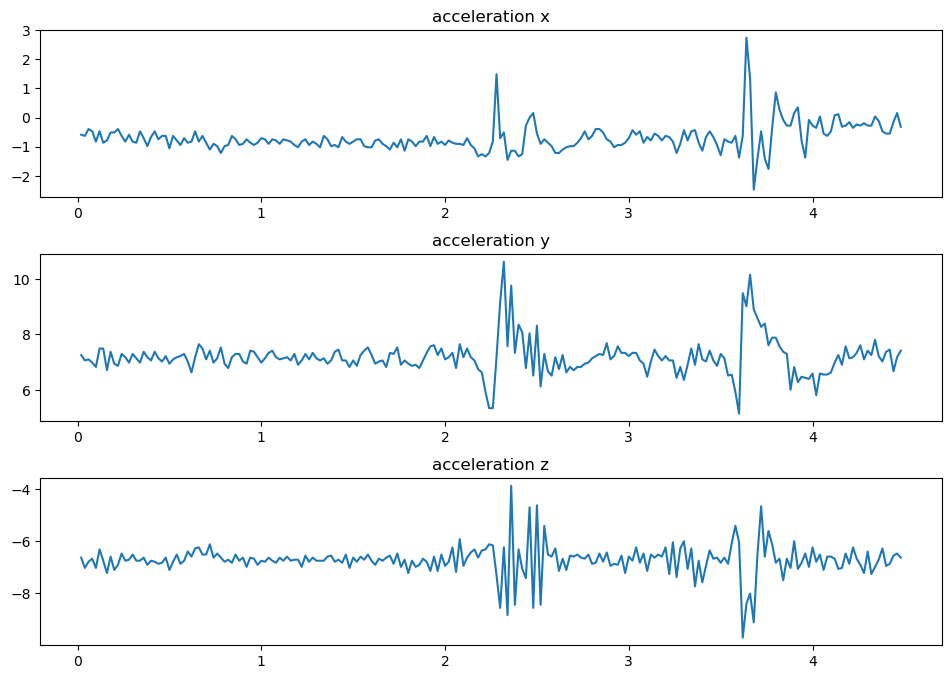

In [5]:
run_number = 1 # Enter run number to visualize
run_id = sample_subgroup_keys[run_number]

acceleration = sample_dict['acc_z'][run_id]

fig, ax = plt.subplots(3, 1, figsize=(10, 7))
fig.tight_layout(pad=2.0)

sampling_frequency = 50
number_of_samples = len(acceleration)
time = np.arange(1, number_of_samples+1) / (sampling_frequency)

# Plot time series of acceleration in x direction
plt.subplot(3, 1, 1)
plt.title('acceleration x')
plt.plot(time, sample_dict['acc_x'][run_id])

# Plot time series of acceleration in y direction
plt.subplot(3, 1, 2)
plt.title('acceleration y')
plt.plot(time, sample_dict['acc_y'][run_id])

# Plot time series of acceleration in z direction
plt.subplot(3, 1, 3)
plt.title('acceleration z')
plt.plot(time, sample_dict['acc_z'][run_id])

count = 0
for attribute in sample_attribute_dict:
    if sample_attribute_dict[attribute].get(run_id) != None:
        print(f'{attribute} = {sample_attribute_dict[attribute][run_id]}')

plt.show()

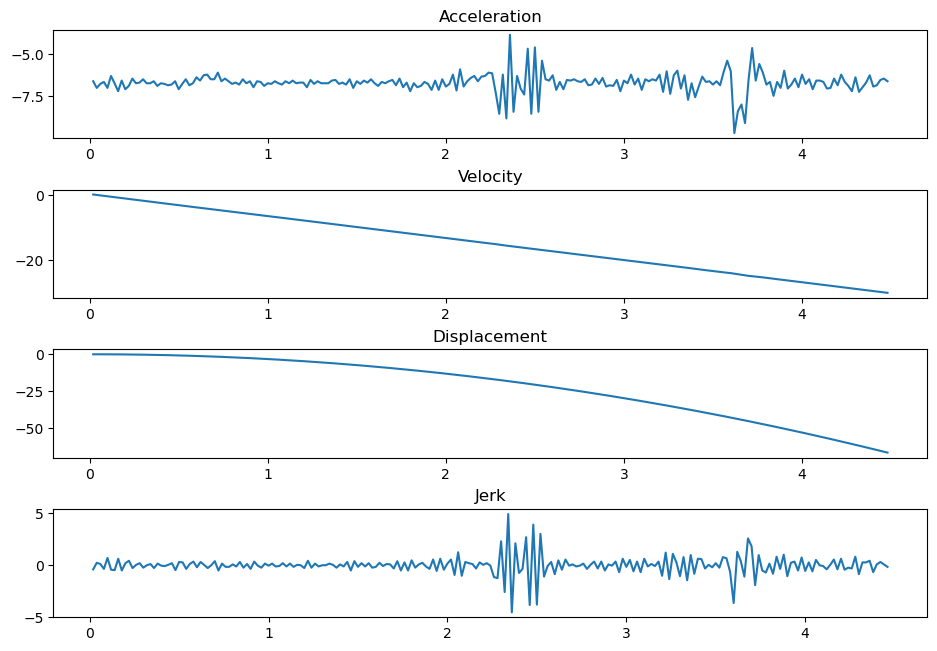

In [6]:
acceleration = sample_dict['acc_z'][run_id]
sampling_frequency = 50
number_of_samples = len(acceleration)
time = np.arange(1, number_of_samples+1) / (sampling_frequency)

fig, ax = plt.subplots(3, 1, figsize=(10, 7))
fig.tight_layout(pad=3.0)

plt.subplot(4, 1, 1)
plt.title('Acceleration')
plt.plot(time, acceleration)

plt.subplot(4, 1, 2)
velocity = sp.integrate.cumtrapz(acceleration, time, initial=0)
plt.plot(time, velocity)
plt.title('Velocity')

plt.subplot(4, 1, 3)
displacement = sp.integrate.cumtrapz(velocity, time, initial=0)
plt.plot(time, displacement)
plt.title('Displacement')

plt.subplot(4, 1, 4)
jerk = [x - acceleration[i - 1] for i, x in enumerate(acceleration)][1:]
plt.plot(time[:len(jerk)], jerk)
plt.title('Jerk')
plt.show()

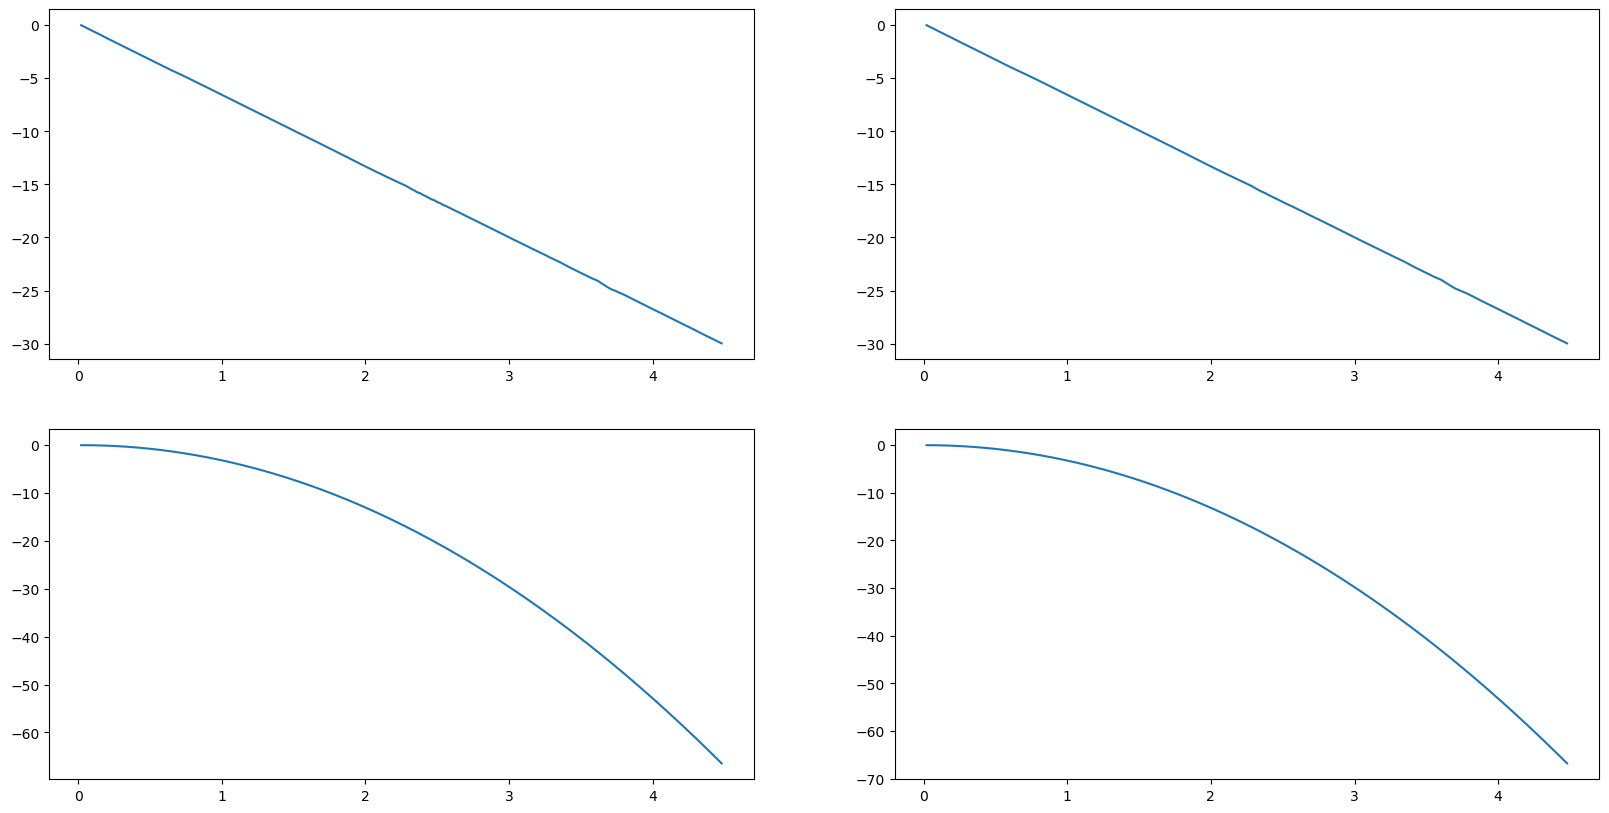

In [7]:
acceleration = sample_dict['acc_z'][run_id]
sampling_frequency = 50
number_of_samples = len(acceleration)
time = np.arange(1, number_of_samples+1) / (sampling_frequency)

dt = time[1] - time[0]
vx = [0]
dx = [0]

for i in range(len(time) - 1):
    vx = vx + [vx[-1] + acceleration[i]*dt]

for i in range(len(time) - 1):
    dx = dx + [dx[-1] + vx[i]*dt]

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

velocity = sp.integrate.cumtrapz(acceleration, time, initial=0)
displacement = sp.integrate.cumtrapz(velocity, time, initial=0)

plt.subplot(2, 2, 1)
plt.plot(time, vx)

plt.subplot(2, 2, 3)
plt.plot(time, dx)

plt.subplot(2, 2, 2)
plt.plot(time, velocity)

plt.subplot(2, 2, 4)
plt.plot(time, displacement)
plt.show()

In [8]:
def compute_feature_vector(acceleration, velocity, displacement, jerk, time):
    """
    Returns the feature matrix given time series data
    """
    acceleration = np.array(acceleration)
    velocity = np.array(velocity)
    displacement = np.array(displacement)
    jerk = np.array(jerk)

    time_series_data = [acceleration, velocity, displacement, jerk]
    feature_vector = []

    for data in time_series_data:
        feature_vector.append(np.mean(data))
        feature_vector.append(np.std(data))
        feature_vector.append(sp.integrate.trapz(acceleration, time))
        feature_vector.extend(np.percentile(data, q=[0, 100]))
        feature_vector.append(float(librosa.feature.zero_crossing_rate(y=data)))
        feature_vector.append(float(librosa.feature.spectral_flatness(y=data)))
        feature_vector.append(float(librosa.feature.spectral_centroid(y=data)))
        feature_vector.append(float(librosa.feature.spectral_rolloff(y=data)))
        feature_vector.append(float(librosa.feature.spectral_bandwidth(y=data)))
        feature_vector.extend(np.percentile(data, q=[25, 50, 75]))
        # break
    
    return(feature_vector)

In [9]:
vector = compute_feature_vector(acceleration, velocity, displacement, jerk, time)
print(len(vector))

52


In [10]:
depth_keys = sample_attribute_dict['depth'].keys()
feature_matrix = []
labels = []

for key in depth_keys:
    # Extract the acceleration and depth data from the dataset
    depth = sample_attribute_dict['depth'][key]
    labels.append(depth)
    acceleration = sample_dict['acc_z'][key]
    
    # Compute the time period
    sampling_frequency = 50
    number_of_samples = len(acceleration)
    time = np.arange(1, number_of_samples+1) / (sampling_frequency)
    
    # Calculate 3 other time series data from the acceleration data
    # Velocity, Displacement and Jerk
    velocity = sp.integrate.cumtrapz(acceleration, time, initial=0)
    displacement = sp.integrate.cumtrapz(velocity, time, initial=0)
    jerk = [x - acceleration[i - 1] for i, x in enumerate(acceleration)][1:]
    
    # Compute feature vector
    feature_vector = compute_feature_vector(acceleration, velocity,
                                    displacement, jerk, time)
    feature_matrix.append(feature_vector)

In [11]:
depth_keys = sample_attribute_dict['depth'].keys()
sum_mean_depth = []
sum_mean_acc = []
min_depth = 1e10
max_depth = -1e10
min_acc = 1e10
max_acc = -1e10

for key in depth_keys:
    # Extract the acceleration and depth data from the dataset
    depth = sample_attribute_dict['depth'][key]
    acceleration = sample_dict['acc_z'][key]
    
    depth = np.array(depth)
    acceleration = np.array(acceleration)
    
    sum_mean_depth.append(depth.mean())
    sum_mean_acc.append(acceleration.mean())
    
    min_depth = min(depth.min(), min_depth)
    min_acc = min(acceleration.min(), min_acc)
    
    max_depth = max(depth.max(), max_depth)
    max_acc = max(acceleration.max(), max_acc)
    
print(f'Mean depth: {np.array(sum_mean_depth).mean()}')
print(f'Mean Acceleration: {np.array(sum_mean_acc).mean()}')

print(f'Minimum depth: {min_depth}')
print(f'Minimum Acceleration: {min_acc}')

print(f'Maximimum depth: {max_depth}')
print(f'Maximimum Acceleration: {max_acc}')

Mean depth: 7.474373576309795
Mean Acceleration: 5.852925055052273
Minimum depth: 4.0
Minimum Acceleration: -28.635
Maximimum depth: 16.0
Maximimum Acceleration: 42.247


In [12]:
feature_matrix = np.array(feature_matrix)
print(feature_matrix.shape)

(878, 52)


In [13]:
from sklearn.model_selection import train_test_split
# data_train, data_val, data_test, labels_train, labels_val, labels_test = train_test_split(feature_matrix, labels, test_size=0.33, random_state=42)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
data_train, data_test, labels_train, labels_test = train_test_split(feature_matrix, labels, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
data_val, data_test, labels_val, labels_test = train_test_split(data_test, labels_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [14]:
print(data_train.shape)
print(data_test.shape)

(658, 52)
(88, 52)


In [15]:
relative_error = []
rmse = []
r2 = []
for i in range(100, 1000+1, 100):
    print(f"Number of Estimators: {i}")
    regressor = RandomForestRegressor(n_estimators=i, random_state=42)
    regressor.fit(data_train, labels_train)

    output = regressor.predict(data_val)
    relative_error.append(metrics.mean_absolute_percentage_error(labels_val, output))    
    rmse.append(np.sqrt(metrics.mean_squared_error(labels_val, output)))    
    r2.append(metrics.r2_score(labels_val, output))

Number of Estimators: 100
Number of Estimators: 200
Number of Estimators: 300
Number of Estimators: 400
Number of Estimators: 500
Number of Estimators: 600
Number of Estimators: 700
Number of Estimators: 800
Number of Estimators: 900
Number of Estimators: 1000


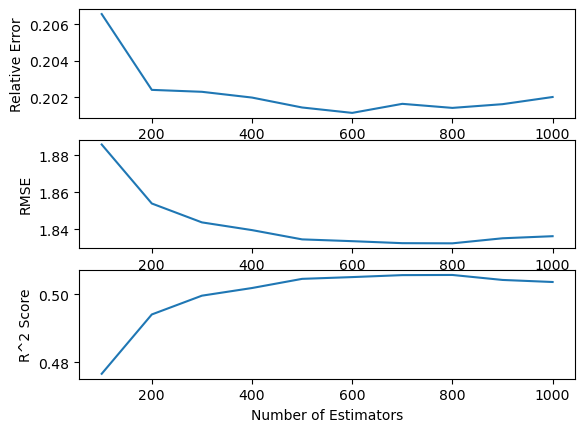

In [16]:
plt.subplot(3, 1, 1)
plt.plot(np.arange(100, 1000+1, 100), relative_error)
plt.ylabel('Relative Error')
plt.xlabel('Number of Estimators')

plt.subplot(3, 1, 2)
plt.plot(np.arange(100, 1000+1, 100), rmse)
plt.ylabel('RMSE')
plt.xlabel('Number of Estimators')

plt.subplot(3, 1, 3)
plt.plot(np.arange(100, 1000+1, 100), r2)
plt.ylabel('R^2 Score')
plt.xlabel('Number of Estimators')
plt.show()

In [17]:
n_estimators = 300
regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
regressor.fit(data_train, labels_train)
pickle.dump(regressor, open(f'{model_dir}/pothole_depth_{n_estimators}estimators.pkl', 'wb'))

In [18]:
# Evaluating the Algorithm
output = regressor.predict(data_test)
print('Relative Error:', metrics.mean_absolute_percentage_error(labels_test, output))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(labels_test, output)))
print('R^2 score:', metrics.r2_score(labels_test, output))  

Relative Error: 0.24670250338979452
Root Mean Squared Error: 1.9345366308266434
R^2 score: 0.47668123470165724


In [19]:
print(data_test.shape)

(88, 52)


## Speed Bump Classification

In [20]:
speedbump_keys = []
feature_matrix = []
labels = []

for key in sample_attribute_dict['type']:
    value = sample_attribute_dict['type'][key]
    if(value == 'Metal_bumps'):
        speedbump_keys.append(key)
    if(value == 'Speed_bump'):
        speedbump_keys.append(key)

for key in speedbump_keys:
    # Extract the acceleration and speed bump type from the dataset
    label = sample_attribute_dict['type'][key]
    labels.append(label)
    acceleration = sample_dict['acc_z'][key]
    
    # Compute the time period
    sampling_frequency = 50
    number_of_samples = len(acceleration)
    time = np.arange(1, number_of_samples+1) / (sampling_frequency)
    
    # Calculate 3 other time series data from the acceleration data
    # Velocity, Displacement and Jerk
    velocity = sp.integrate.cumtrapz(acceleration, time, initial=0)
    displacement = sp.integrate.cumtrapz(velocity, time, initial=0)
    jerk = [x - acceleration[i - 1] for i, x in enumerate(acceleration)][1:]
    
    # Compute feature vector
    feature_vector = compute_feature_vector(acceleration, velocity,
                                    displacement, jerk, time)
    feature_matrix.append(feature_vector)

In [21]:
feature_matrix = np.array(feature_matrix)
labels = np.array(labels)
print(feature_matrix.shape)

(519, 52)


In [22]:
from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
data_train, data_test, labels_train, labels_test = train_test_split(feature_matrix, labels, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
data_val, data_test, labels_val, labels_test = train_test_split(data_test, labels_test, 
                                                                test_size=test_ratio/(test_ratio + validation_ratio), 
                                                                random_state=42)

In [25]:
n_estimators = 100
clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)
clf.fit(data_train, labels_train)
pickle.dump(clf, open(f'{model_dir}/speedbump_classifier_{n_estimators}estimators.pkl', 'wb'))

In [26]:
preds = clf.predict(data_test)
y_test = [label == 'Metal_bumps' for label in labels_test]
y_pred = [pred == 'Metal_bumps' for pred in preds]
metrics.roc_auc_score(y_test, y_pred)

0.75

## Apply Morse wavelets to the current dataset 

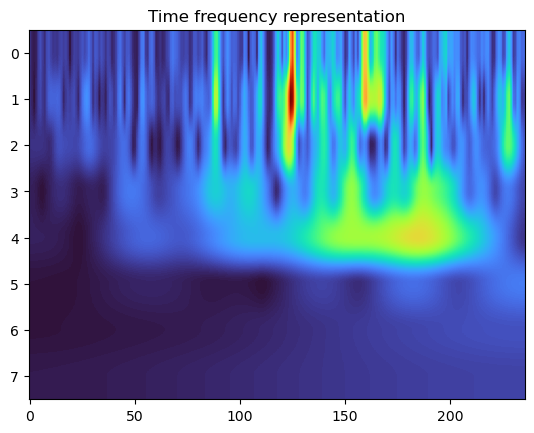

In [35]:
run_number = 4 # Enter run number to visualize
run_id = sample_subgroup_keys[run_number]

x = sample_dict['acc_z'][run_id]
x = np.array(x)

gmw = MorseWavelet(gamma=3, beta=1.3333)
Wx, *_ = ghostipy.spectral.cwt(x, wavelet=gmw, voices_per_octave=1)
plt.title('Time frequency representation')
plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')

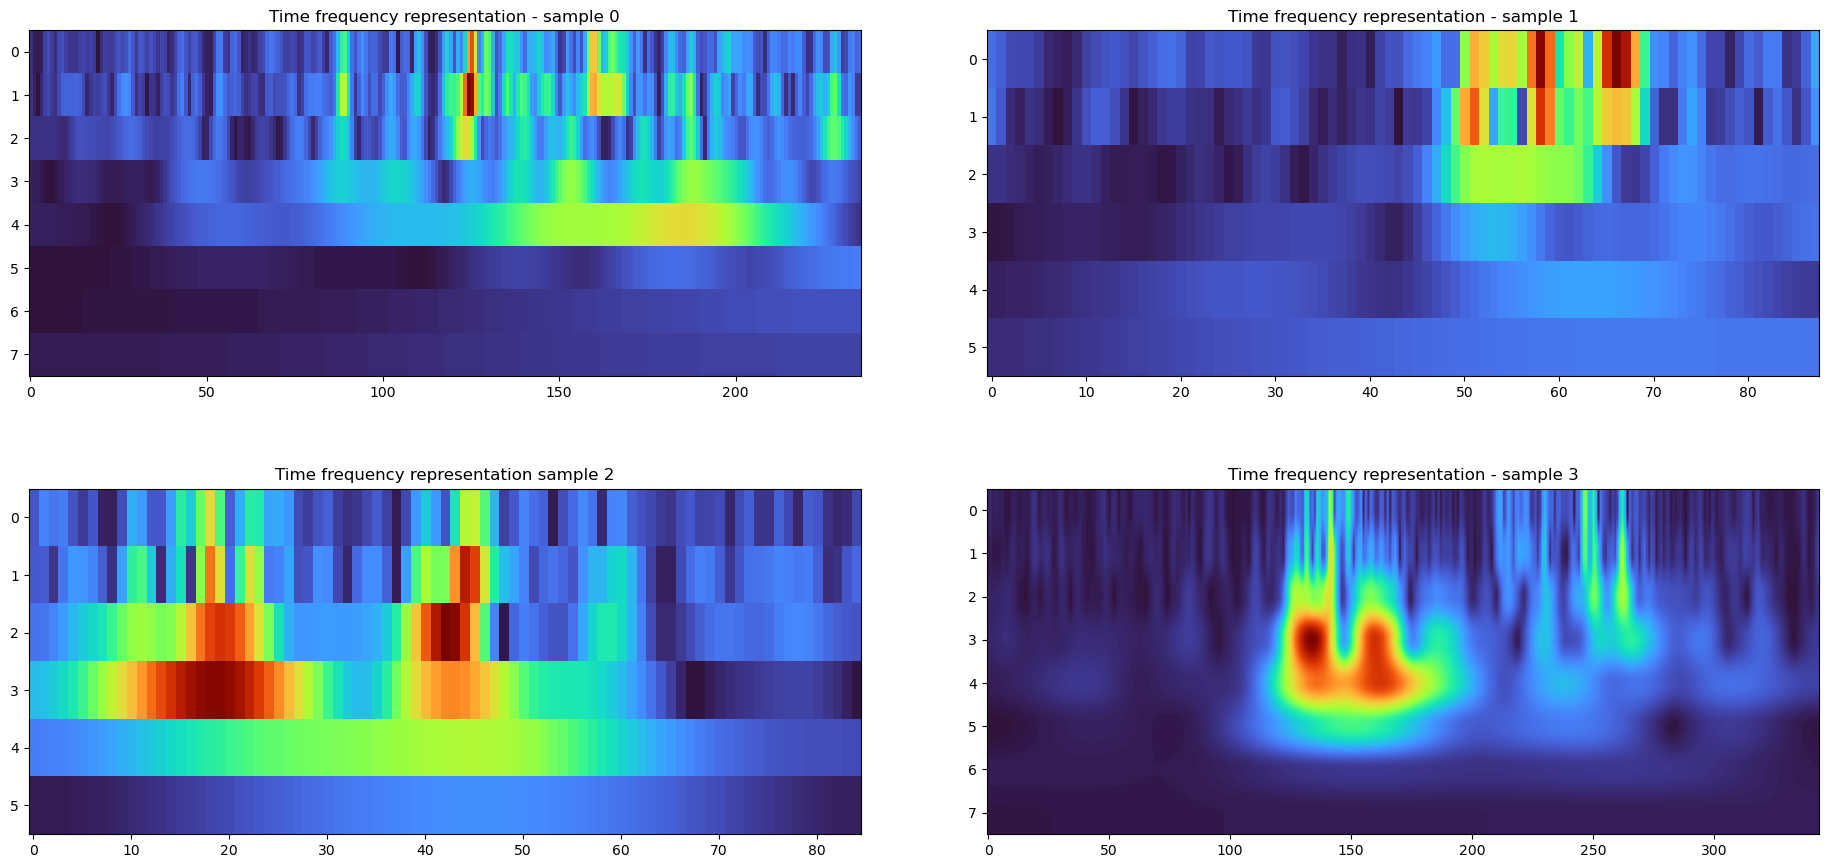

In [42]:
run_number = 4 # Enter run number to visualize
run_id = sample_subgroup_keys[run_number:run_number+4]


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.tight_layout(pad=6.0)

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = sample_dict['acc_z'][run_id[0]]
x = np.array(x)
Wx, *_  = ghostipy.spectral.cwt(x, wavelet=gmw, voices_per_octave=1)
ax[0][0].set_title('Time frequency representation - sample 0')
ax[0][0].imshow(np.abs(Wx), aspect='auto', cmap='turbo')

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = sample_dict['acc_z'][run_id[1]]
x = np.array(x)
Wx, *_ = ghostipy.spectral.cwt(x, wavelet=gmw, voices_per_octave=1)
ax[0][1].set_title('Time frequency representation - sample 1')
ax[0][1].imshow(np.abs(Wx), aspect='auto', cmap='turbo')

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = sample_dict['acc_z'][run_id[2]]
x = np.array(x)
Wx, *_  = ghostipy.spectral.cwt(x, wavelet=gmw, voices_per_octave=1)
ax[1][0].set_title('Time frequency representation sample 2')
ax[1][0].imshow(np.abs(Wx), aspect='auto', cmap='turbo')

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = sample_dict['acc_z'][run_id[3]]
x = np.array(x)
Wx, *_ = ghostipy.spectral.cwt(x, wavelet=gmw, voices_per_octave=1)
ax[1][1].set_title('Time frequency representation - sample 3')
ax[1][1].imshow(np.abs(Wx), aspect='auto', cmap='turbo')

In [43]:
count = 0
for attribute in sample_attribute_dict:
    for run in run_id:
        if sample_attribute_dict[attribute].get(run) != None:
            print(f'{attribute} = {sample_attribute_dict[attribute][run]}')

depth = 6.0
depth = 6.5
depth = 16.0
dim1 = 82.0
dim1 = 58.0
dim1 = 110.0
dim2 = 34.0
dim2 = 46.0
dim2 = 59.0
condition = bad
event = 5794dfea-1dd6-4ee5-9198-242de74036d9
event = c2320087-6163-476c-b4aa-ce630700aaea
event = 961742d0-6534-466a-a275-3a5dffa09c48
event = 501e9fc7-3277-43fe-91be-93d809352fe1
placement = Right door
placement = Glove compartment
placement = Console seats
placement = Left door
speed = 0
speed = 56.7
speed = 13.5
speed = 11.197674418604652
type = Pothole
type = Metal_bumps
type = Pothole
type = Pothole
vehicle = Chevrolet Cruze 2010
vehicle = VW Pointer 2004
vehicle = Kia RIO 2018
vehicle = Chevrolet Express van 2013
